Some comments

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import copy
import numpy as np
repo_dir = '/datasets/hsc/repo/rerun/DM-13666/UDEEP'
assert os.path.isdir(repo_dir)

import lsst.daf.persistence as daf_persistence
butler = daf_persistence.Butler(repo_dir)

In [3]:
coadd_skymap = butler.get('deepCoadd_skyMap')

In [4]:
#dir(coadd_skymap)

In [5]:
#help(coadd_skymap.findTractPatchList)

In [6]:
import h5py
spatial_lookup_filename = '/project/danielsf/valid_hsc_visit_extent_udeep.h5'
assert os.path.isfile(spatial_lookup_filename)
spatial_lookup = h5py.File(spatial_lookup_filename, 'r')

Specify the region of sky observed in visit 11625

In [7]:
visit_num = spatial_lookup['visit'][11625]

In [8]:
all_visit = np.where(spatial_lookup['visit'][()]==visit_num)

In [9]:
ra_min = spatial_lookup['ra_min'][()][all_visit].min()
ra_max = spatial_lookup['ra_max'][()][all_visit].max()
dec_min = spatial_lookup['dec_min'][()][all_visit].min()
dec_max = spatial_lookup['dec_max'][()][all_visit].max()

In [10]:
all_coverage = np.where(np.logical_and(spatial_lookup['ra_center'][()]>ra_min,
                        np.logical_and(spatial_lookup['ra_center'][()]<ra_max,
                        np.logical_and(spatial_lookup['dec_center'][()]>dec_min,
                                       spatial_lookup['dec_center'][()]<dec_max))))

Find all the (tract, patch) pairs in that region

In [11]:
import lsst.geom as lsst_geom

In [12]:
pt_list = []
for ra in np.arange(ra_min, ra_max, 0.005):
    for dec in np.arange(dec_min, dec_max, 0.005):
        pt_list.append(lsst_geom.SpherePoint(ra, dec, lsst_geom.radians))

In [13]:
tract_patch_list = coadd_skymap.findTractPatchList(pt_list)

In [14]:
type(tract_patch_list[0][1][0])

lsst.skymap.patchInfo.PatchInfo

In [15]:
butler.getKeys(datasetType='deepCoadd')

{'filter': str, 'tract': int, 'patch': str}

Define a method to select stars

In [16]:
def select_stars(dataset, calib):
    """
    Select all sources with
    base_ClassificationExtendedness_value == 0
    & base_PsfFlux_flag == 0
    & np.abs(PsfMag-CModelMag)<0.03
    & PsfMag<25.0
    
    Parameters
    ----------
    dataset -- a src or deepCoadd_forcedSrc catalog
    calib -- the photometric calibration object needed to convert fluxes into mags
    
    Returns
    -------
    numpy array of PSF magnitudes
    numpy array of cModel magnitudes
    numpy array of booleans set to 'True' for everything that meets the criteria above
    """
    extendedness_flag = dataset['base_ClassificationExtendedness_value']==0
    well_measured_flag = dataset['base_PsfFlux_flag']==0
    mag = calib.instFluxToMagnitude(dataset, 'base_PsfFlux')[:,0]
    colnames = dataset.getSchema().getNames()
    if 'modelfit_CModel_flux' in colnames:
        model_mag = calib.instFluxToMagnitude(dataset, 'modelfit_CModel')[:,0]
        mag_m_model_flag = np.abs(mag-model_mag)<0.03
    else:
        model_mag = np.NaN*np.ones(len(mag), dtype=float)
        mag_m_model_flag = np.ones(len(mag), dtype=bool)
    brightness_flag = mag<25.0
    brightness_finite = np.isfinite(mag)
    flag = extendedness_flag & well_measured_flag & mag_m_model_flag & brightness_finite & brightness_flag
    return mag, model_mag, flag

Get all the clear stars from the deepCoadd_forcedSrc catalog.  Plot the stellar locus.

In [17]:
%%time
coadd_unq_id = []
coadd_g_mags = []
coadd_r_mags = []
coadd_i_mags = []

coadd_g_model = []
coadd_r_model = []
coadd_i_model = []

coadd_ra = []
coadd_dec = []

for tract_sublist in tract_patch_list:
    tract_id = tract_sublist[0].getId()
    for patch_obj in tract_sublist[1]:
        patch_id = str(patch_obj.getIndex()).replace('(','').replace(')','').replace(' ','')
        blank_data_id = {'tract': tract_id, 'patch':patch_id}

        data_id_g = copy.deepcopy(blank_data_id)
        data_id_g['filter'] = 'HSC-G'
        data_id_r = copy.deepcopy(blank_data_id)
        data_id_r['filter'] = 'HSC-R'
        data_id_i = copy.deepcopy(blank_data_id)
        data_id_i['filter'] = 'HSC-I'

        if not butler.datasetExists('deepCoadd_forced_src', dataId=data_id_g):
            continue

        if not butler.datasetExists('deepCoadd_forced_src', dataId=data_id_r):
            continue

        if not butler.datasetExists('deepCoadd_forced_src', dataId=data_id_i):
            continue
        #print('loading %s' % str(blank_data_id))
        
        data_g = butler.get('deepCoadd_forced_src', dataId=data_id_g)#.asAstropy()
        data_r = butler.get('deepCoadd_forced_src', dataId=data_id_r)#.asAstropy()
        data_i = butler.get('deepCoadd_forced_src', dataId=data_id_i)#.asAstropy()

        np.testing.assert_array_equal(data_g['id'], data_r['id'])
        np.testing.assert_array_equal(data_g['id'], data_i['id'])
        np.testing.assert_array_equal(data_g['coord_ra'], data_r['coord_ra'])
        np.testing.assert_array_equal(data_g['coord_ra'], data_i['coord_ra'])
        np.testing.assert_array_equal(data_g['coord_dec'], data_r['coord_dec'])
        np.testing.assert_array_equal(data_g['coord_dec'], data_r['coord_dec'])

        calib_g = butler.get('deepCoadd_calexp_photoCalib', dataId=data_id_g)
        calib_r = butler.get('deepCoadd_calexp_photoCalib', dataId=data_id_r)
        calib_i = butler.get('deepCoadd_calexp_photoCalib', dataId=data_id_i)
    
        g_mag, g_model, star_g = select_stars(data_g, calib_g)
        r_mag, r_model, star_r = select_stars(data_r, calib_r)
        i_mag, i_model, star_i = select_stars(data_i, calib_i)
        stars = np.where(star_g & star_r & star_i)

        coadd_g_mags.append(g_mag[stars])
        coadd_g_model.append(g_model[stars])
        coadd_r_mags.append(r_mag[stars])
        coadd_r_model.append(r_model[stars])
        coadd_i_mags.append(i_mag[stars])
        coadd_i_model.append(i_model[stars])
    
        coadd_ra.append(data_g['coord_ra'][stars])
        coadd_dec.append(data_g['coord_dec'][stars])
        coadd_unq_id.append(data_g['id'][stars])

    
        #coadd_g_mags.append(calib_g.instFluxToMagnitude(data_g['base_PsfFlux_instFlux']))
        #coadd_r_mags.append(calib_r.instFluxToMagnitude(data_r['base_PsfFlux_instFlux']))
        #coadd_i_mags.append(calib_i.instFluxToMagnitude(data_i['base_PsfFlux_instFlux']))

    
coadd_unq_id = np.concatenate(coadd_unq_id)
coadd_ra = np.concatenate(coadd_ra)
coadd_dec = np.concatenate(coadd_dec)
coadd_g_mags = np.concatenate(coadd_g_mags)
coadd_r_mags = np.concatenate(coadd_r_mags)
coadd_i_mags = np.concatenate(coadd_i_mags)
coadd_g_model = np.concatenate(coadd_g_model)
coadd_r_model = np.concatenate(coadd_r_model)
coadd_i_model = np.concatenate(coadd_i_model)

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in less


CPU times: user 1min 9s, sys: 11.6 s, total: 1min 21s
Wall time: 2min 5s


In [18]:
print(len(coadd_g_mags))

18129


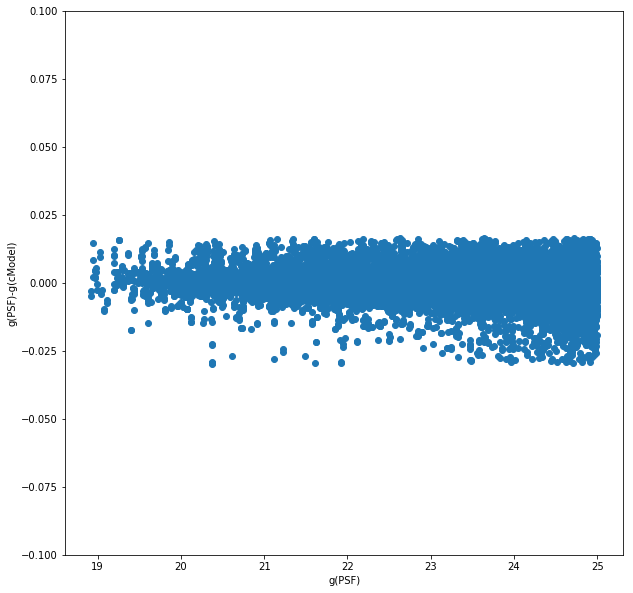

18.918516828728663


In [19]:
plt.figure(figsize=(10,10))
plt.scatter(coadd_g_mags, coadd_g_mags-coadd_g_model)
plt.xlabel('g(PSF)')
plt.ylabel('g(PSF)-g(cModel)')
plt.ylim(-0.1,0.1)
plt.show()
print(coadd_g_mags.min())

18129


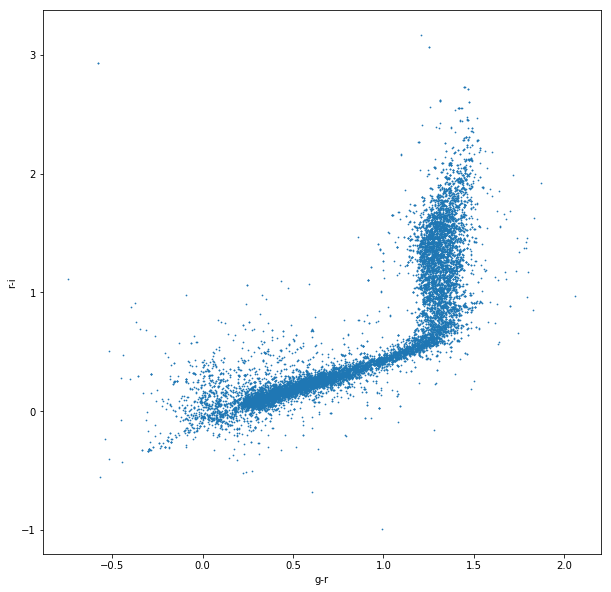

In [20]:
plt.figure(figsize=(10,10))
#plt.scatter(coadd_g_mags-coadd_r_mags, coadd_r_mags-coadd_i_mags,s=0.5)
valid_meas = np.logical_and(np.isfinite(coadd_g_mags),
                 np.logical_and(np.isfinite(coadd_r_mags), np.isfinite(coadd_i_mags)))

bright_enough = np.logical_and(coadd_g_mags<25.0,
                np.logical_and(coadd_r_mags<25.0, coadd_i_mags<25.0))

valid = np.where(np.logical_and(valid_meas, bright_enough))
print(len(valid[0]))
plt.scatter(coadd_g_mags-coadd_r_mags,
            coadd_r_mags-coadd_i_mags,s=0.5)

#plt.hist2d(coadd_g_mags[valid]-coadd_r_mags[valid],
#           coadd_r_mags[valid]-coadd_i_mags[valid], bins=(200,200), cmap=plt.cm.jet)
plt.xlabel('g-r')
plt.ylabel('r-i')
#plt.ylim(20,35)
#plt.xlim(-5,5)
plt.show()

Build a KDTree of these sources for association with single image sources later on

In [21]:
import scipy.spatial as scipy_spatial
coadd_ra_normalized = coadd_ra/np.cos(coadd_dec)
coadd_spatial_data = np.array([coadd_ra_normalized, coadd_dec]).transpose()
coadd_spatial_tree = scipy_spatial.cKDTree(coadd_spatial_data, leafsize=16)

In [ ]:
print(len(all_coverage[0]))

Get the RA, Dec, magnitue, and filter of all of the single image stars in HSC UDEEP

(This will take a few hours, if you haven't already queried them from the butler and stored them in an hdf5 file)

In [22]:
#%%prun -s cumulative -D sfd_profile.sav
import time

single_exposure_data_name = '/project/danielsf/udeep_single_visit_all_of_them.h5'

if os.path.exists(single_exposure_data_name):
    with h5py.File(single_exposure_data_name, 'r') as in_file:
        single_ra = in_file['ra'][()]
        single_dec = in_file['dec'][()]
        single_mag = in_file['mag'][()]
        single_filter = in_file['filter'][()] 

else:
    t_start = time.time()
    single_ra = []
    single_dec = []
    single_mag = []
    single_filter = []
    ct_single = 0
    n_visits = len(spatial_lookup['filter'][()])

    for single_dex in range(n_visits):
        filter_name = spatial_lookup['filter'][()][single_dex]
        data_id_single = {'visit': int(spatial_lookup['visit'][()][single_dex]),
                          'ccd': int(spatial_lookup['ccd'][()][single_dex]),
                          'filter': filter_name.decode()}
        try:
            data_single = butler.get('src', dataId=data_id_single, immediate=True)
            calib_single = butler.get('calexp_photoCalib', dataId=data_id_single, immediate=True)
        except:
            continue
        psf_mag, model_mag, star_dex = select_stars(data_single, calib_single)
        single_ra.append(data_single['coord_ra'][star_dex])
        single_dec.append(data_single['coord_dec'][star_dex])
        single_mag.append(psf_mag[star_dex])
        single_filter.append([filter_name]*np.sum(star_dex))
        assert len(single_filter[-1]) == len(single_ra[-1])
        ct_single += 1
        if ct_single % 200 == 0:
            duration = (time.time()-t_start)/3600.0
            per = duration/ct_single
            pred = per*n_visits
            print('got %d in %.2e hrs (%.2e; %.2e)' % (ct_single, duration, per, pred))

    single_ra = np.concatenate(single_ra)
    single_dec = np.concatenate(single_dec)
    single_mag = np.concatenate(single_mag)
    single_filter = np.concatenate(single_filter)

    with h5py.File(single_exposure_data_name, 'w') as out_file:
        out_file.create_dataset('ra', data=single_ra)
        out_file.create_dataset('dec', data=single_dec)
        out_file.create_dataset('mag', data=single_mag)
        out_file.create_dataset('filter', data=single_filter)

    with open('/project/danielsf/single_data_log.txt', 'w') as out_file:
        out_file.write('all done %d\n' % ct_single)

    print('all done')



In [ ]:
print(len(single_ra))

Associate single image sources with coadd forced sources

In [23]:
single_ra_normalized = single_ra/np.cos(single_dec)
single_spatial_data = np.array([single_ra_normalized, single_dec]).transpose()

In [24]:
%%time
fit_dist, fit_dex = coadd_spatial_tree.query(single_spatial_data, k=2)

CPU times: user 15 s, sys: 279 ms, total: 15.3 s
Wall time: 15.3 s


In [25]:
# Select only those stars that are within 0.05 arcseconds of a coadd force source
# and for whom the nearest neighbor is 10 times closer than the next nearest neighbor

fit_d_trans = fit_dist.transpose()
fit_d_ratio = fit_d_trans[0]/fit_d_trans[1]
fit_d_arcsec= fit_d_trans[0]/np.radians(1/3600)

valid = np.where(np.logical_and(fit_d_ratio<0.1, fit_d_arcsec<0.05))

In [ ]:
print(len(valid[0]))

In [26]:
fit_dex_trans = fit_dex.transpose()
single_fit_id = fit_dex_trans[0][valid]
single_fit_unq_id, unq_cts = np.unique(single_fit_id, return_counts=True)
print(len(single_fit_id))
print(len(single_fit_unq_id))
single_fit_ra = single_ra[valid]
single_fit_dec = single_dec[valid]
single_fit_mag = single_mag[valid]
single_fit_filter = single_filter[valid]

231722
2952


Find the relevant statistics of each source's measured magnitude distributions

In [27]:
unq_filter_list = np.unique(single_fit_filter)
rms_by_filter = {}
mean_by_filter = {}
median_by_filter = {}
ct_by_filter = {}
for filter_name in unq_filter_list:
    rms_by_filter[filter_name] = []
    mean_by_filter[filter_name] = []
    median_by_filter[filter_name] = []
    ct_by_filter[filter_name] = []
    is_filter = (single_fit_filter==filter_name)
    for unq_id in single_fit_unq_id:
        is_obj = (single_fit_id==unq_id)
        of_interest = is_filter & is_obj
        if np.sum(of_interest)>10:
            rms_by_filter[filter_name].append(np.std(single_fit_mag[of_interest]))
            mean_by_filter[filter_name].append(np.mean(single_fit_mag[of_interest]))
            median_by_filter[filter_name].append(np.median(single_fit_mag[of_interest]))
            ct_by_filter[filter_name].append(np.sum(of_interest))

for filter_name in rms_by_filter:
    rms_by_filter[filter_name] = np.array(rms_by_filter[filter_name])
    mean_by_filter[filter_name] = np.array(mean_by_filter[filter_name])
    median_by_filter[filter_name] = np.array(median_by_filter[filter_name])
    ct_by_filter[filter_name] = np.array(ct_by_filter[filter_name])

Plot distribution of RMS scatter in magnitude measurements

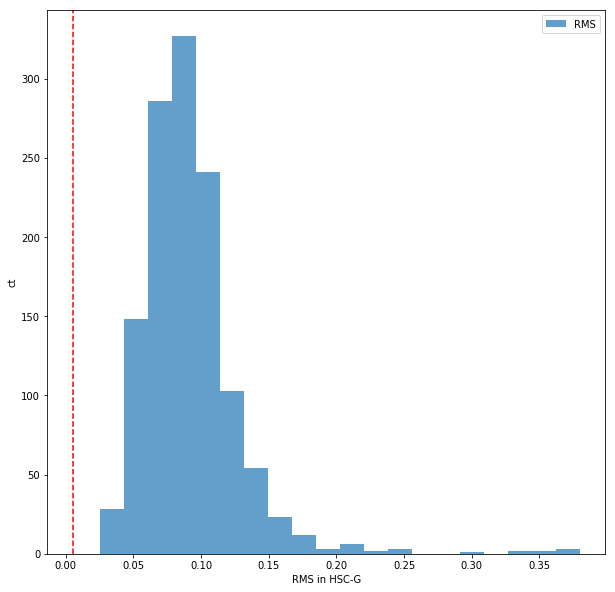

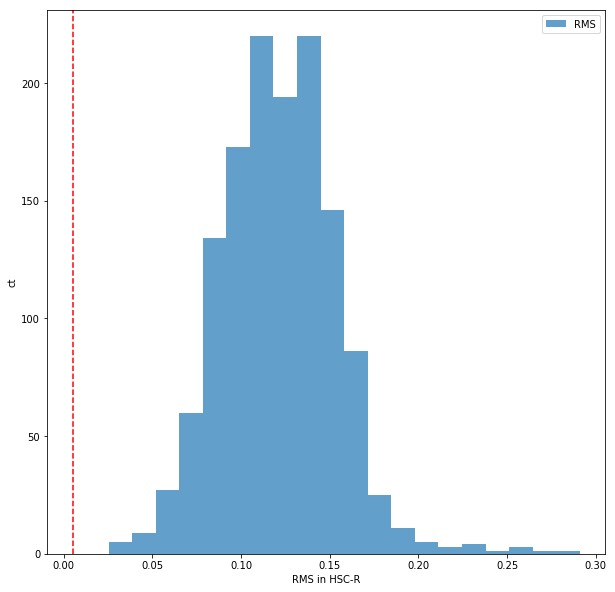

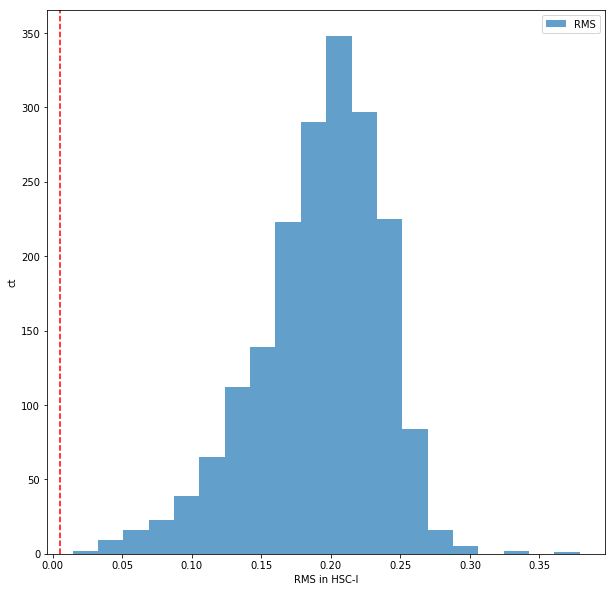

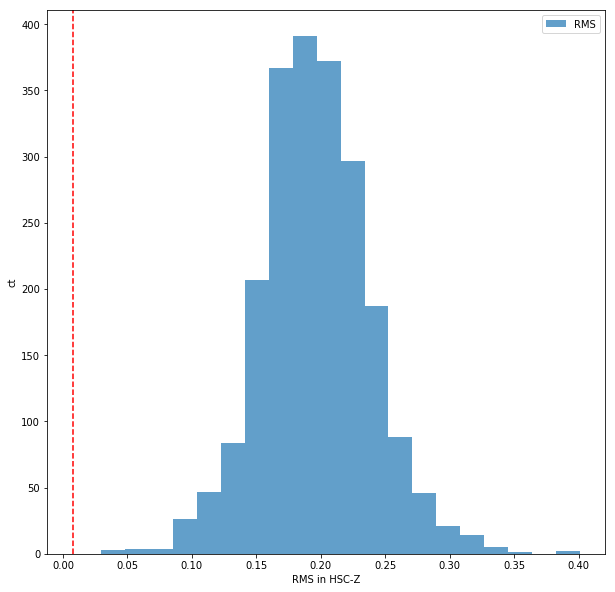

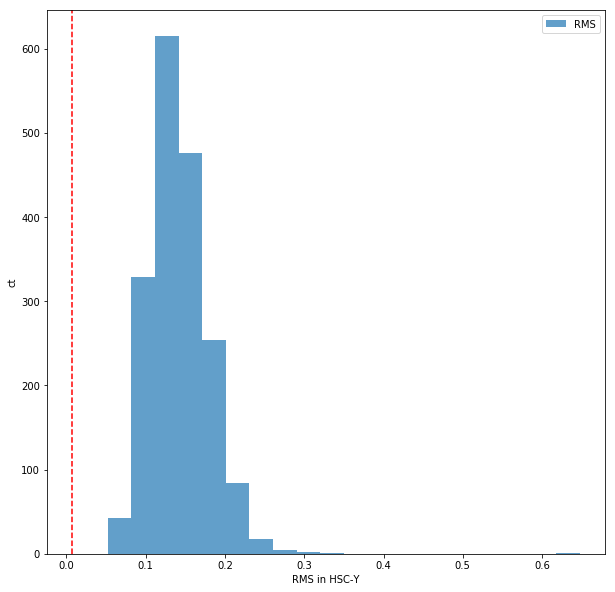

In [28]:
pa_limit = {}
pa_limit[b'HSC-Y'] = 0.0075
pa_limit[b'HSC-Z'] = 0.0075
pa_limit[b'HSC-G'] = 0.005
pa_limit[b'HSC-R'] = 0.005
pa_limit[b'HSC-I'] = 0.005

for bp in [b'HSC-G', b'HSC-R', b'HSC-I', b'HSC-Z', b'HSC-Y']:
    plt.figure(figsize=(10,10))
    #plt.hist(median_by_filter[bp]-mean_by_filter[bp], label='median-mean', bins=20)
    plt.hist(rms_by_filter[bp], alpha=0.7, label='RMS', bins=20)
    plt.legend()
    plt.xlabel('RMS in %s' % bp.decode())
    plt.ylabel('ct')
    plt.axvline(pa_limit[bp], color='r', linestyle='--')
    plt.show()

### Do not execute below this line

In [ ]:
mag_of_interest = single_fit_mag[is_y_and_obj]
print(np.mean(mag_of_interest))
print(np.std(mag_of_interest))
print(np.median(mag_of_interest-np.mean(mag_of_interest)))

In [ ]:
single_id = single_unq_id
single_unq_id = np.unique(single_id)

In [ ]:
print(single_ra.min(), single_ra.max())
print(single_dec.min(), single_dec.max())
print(coadd_dec.min(), coadd_dec.max())

In [ ]:
in_ra = (single_ra>=coadd_ra.min()) & (single_ra<=coadd_ra.max())
in_dec = (single_dec>=coadd_dec.min()) & (single_dec<=coadd_dec.max())
inside = in_ra & in_dec
print(np.sum(inside))
print(single_spatial_data.shape)
print(len(single_ra))

In [ ]:
ct_id = []
for ii in single_unq_id:
    ct_id.append(len(np.where(single_id==ii)[0]))
ct_id = np.array(ct_id)
print(np.argmax(ct_id))

In [ ]:
valid = np.where(single_id==single_unq_id[1168])

In [ ]:
print(np.unique(single_filter))

In [ ]:
np.unique(spatial_lookup['ra_max'][()])

In [ ]:
dex = all_coverage[0][0]
data_id_single = {'visit': int(spatial_lookup['visit'][()][dex]),
                  'ccd': int(spatial_lookup['ccd'][()][dex]),
                  'filter': spatial_lookup['filter'][()][dex].decode()}
data_single = butler.get('src', dataId=data_id_single)
calib_single = butler.get('calexp_photoCalib', dataId=data_id_single)

In [ ]:
#data_single.getSchema()

In [ ]:
psf_mag, model_mag, star_dex = select_stars(data_single, calib_single)

In [ ]:
subs = data_single.subset(star_dex)

In [ ]:
psf_mag_2, model_mag_2, star_dex_2 = select_stars(subs, calib_single)

In [ ]:
np.array_equal(subs['id'], data_single['id'][star_dex])

In [ ]:
normalized_ra = data_single['coord_ra']/np.cos(data_single['coord_dec'])
spatial_data = np.array([normalized_ra, data_single['coord_dec']]).transpose()

In [ ]:
fit_dist, fit_dex = coadd_spatial_tree.query(spatial_data)

In [ ]:
within_arcsec = np.where(np.logical_and(fit_dist<np.radians(1.0/3600.0),
                                        data_single['base_ClassificationExtendedness_value']==0))

In [ ]:
id_within_arcsec = data_single['id'][within_arcsec]

In [ ]:
print(coadd_unq_id.min(),coadd_unq_id.max())
print(id_within_arcsec.min(),id_within_arcsec.max())

In [ ]:
data_single['base_ClassificationExtendedness_value'][within_arcsec]

In [ ]:
fit_dex_within = fit_dex[within_arcsec]
print(len(fit_dex_within))
print(len(np.unique(fit_dex_within)))

In [ ]:
data_g = butler.get('deepCoadd_forced_src', dataId=data_id_g).asAstropy()
data_r = butler.get('deepCoadd_forced_src', dataId=data_id_r).asAstropy()
data_i = butler.get('deepCoadd_forced_src', dataId=data_id_i).asAstropy()

In [ ]:
for name in data.colnames:
    if 'endedness' in name:
        print(name)

In [ ]:
data_id = {}
data_id['visit']=6292
data_id['ccd']=38
data_id['filter']='HSC-G'
data_id_single['ccd'] = 38

print('data_id: ',data_id)
print('data_id_single: ',data_id_single)

print('ccd',data_id['ccd']==data_id_single['ccd'])
print('visit',data_id['visit']==data_id_single['visit'])
print('filter',data_id['filter']==data_id_single['filter'])
print('data_id==data_id_single: ',data_id==data_id_single)

print('data_id exists: ',butler.datasetExists('src', dataId=data_id))
print('data_id_single exists: ',butler.datasetExists('src', dataId=data_id_single))

print(type(data_id['filter']))
print(type(data_id_single['filter']))

In [ ]:
data_id = {}
data_id['ccd'] = 38
data_id['visit'] = 6292
data_id['filter'] = 'HSC-G'
print(butler.datasetExists('src', dataId=data_id))
print()

data_id_b = {}
data_id_b['ccd'] = 38
data_id_b['visit'] = 6292
data_id_b['filter'] = np.bytes_('HSC-G').decode()
print(butler.datasetExists('src', dataId=data_id_b))
print()
filter_id = spatial_lookup['filter'][()][dex]
print(filter_id,type(filter_id))
data_id_b['filter'] = filter_id.decode()
print(data_id_b)
print(butler.datasetExists('src', dataId=data_id_b))

print(data_id_b==data_id_single)
print(butler.datasetExists('src', dataId=data_id_single))
data_id_single['filter'] = 'HSC-G'
data_id_single['visit'] = 6292
#data_id_single.pop('visist')
print('does it exist ',butler.datasetExists('src', dataId=data_id_single))
type(data_id_single['visit'])

In [ ]:
data_id_single

In [ ]:
np.bytes_('abcd').decode()

In [ ]:
data_g.getSchema()

In [ ]:
data_g['modelfit_CModel_flux']

In [ ]:
stars = np.where(data_g['base_ClassificationExtendedness_value']==0)

In [ ]:
stars_r = np.where(data_r['base_ClassificationExtendedness_value']==0)
data_g['id'][:10]

In [ ]:
np.testing.assert_array_equal(data_g['id'], data_r['id'])
np.testing.assert_array_equal(data_g['id'], data_i['id'])

In [ ]:
stars_r[0]

In [ ]:
stars[0]

In [ ]:
len(stars_r[0])

In [ ]:
len(stars[0])

In [ ]:
stars_r[0][3]

In [ ]:
np.any(data_g['base_ClassificationExtendedness_flag'][stars])

In [ ]:
stars = np.where(np.logical_and(data_g['base_ClassificationExtendedness_value']==0,
                 np.logical_and(data_i['base_ClassificationExtendedness_value']==0,
                                data_r['base_ClassificationExtendedness_value']==0)))

In [ ]:
len(stars[0])

In [ ]:
calib = butler.get('deepCoadd_calexp_photoCalib', dataId=data_id_r)

In [ ]:
dir(calib)

In [ ]:
help(calib.instFluxToMagnitude)

In [ ]:
help(calib_g.instFluxToMagnitude)

In [ ]:
type(data_g.getSchema().getNames())

In [ ]:
colnames = data_g.getSchema().getNames()

In [ ]:
'modelfit_CModel_flux' in colnames

In [ ]:
len(all_coverage[0])

In [ ]:
dir(butler)

In [ ]:
help(butler.get)

Find udeep regions

In [ ]:
udeep_center_ra = [30.0, 240.0, 14*15.0]
udeep_regions = []
for ii in range(3):
    udeep_regions.append([[360.0,0.0],[90.0,-90.0]])

In [ ]:
ra_c_arr = np.degrees(spatial_lookup['ra_center'][()])
dec_c_arr = np.degrees(spatial_lookup['dec_center'][()])
ra_min_arr = np.degrees(spatial_lookup['ra_min'][()])
ra_max_arr = np.degrees(spatial_lookup['ra_max'][()])
dec_min_arr = np.degrees(spatial_lookup['dec_min'][()])
dec_max_arr = np.degrees(spatial_lookup['dec_max'][()])
drac0 = np.abs(ra_c_arr-udeep_center_ra[0])
drac1 = np.abs(ra_c_arr-udeep_center_ra[1])
drac2 = np.abs(ra_c_arr-udeep_center_ra[2])

v0 = np.where(np.logical_and(drac0<drac1, drac0<drac2))
v1 = np.where(np.logical_and(drac1<=drac0, drac1<drac2))
v2 = np.where(np.logical_and(drac2<=drac0, drac2<=drac0))

print(len(v0[0])+len(v1[0])+len(v2[0]))
print(len(ra_c_arr))
print(len(v1[0]))

for ii, vv in enumerate([v0, v1, v2]):
    if len(vv[0])>0:
        udeep_regions[ii][0][0] = ra_min_arr[vv].min()
        udeep_regions[ii][0][1] = ra_max_arr[vv].max()
        udeep_regions[ii][1][0] = dec_min_arr[vv].min()
        udeep_regions[ii][1][1] = dec_max_arr[vv].max()


In [ ]:
udeep_regions[0]

In [ ]:
udeep_regions[1]

In [ ]:
udeep_regions[2]